## Noise Classification in Intravascular Ultrasound (3 Separate CNNs)

In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import graphviz
import seaborn as sns
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from skimage.transform import resize
from keras.models import Model, load_model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, concatenate, MaxPooling2D, Conv2D, Conv2DTranspose, \
UpSampling2D, BatchNormalization, Reshape, Flatten, Dropout
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
import cv2
from keras import backend as K
K.set_image_dim_ordering('tf')
import os

tf.logging.set_verbosity(tf.logging.INFO)
print("Tensorflow Version : "+tf.VERSION)

Tensorflow Version : 1.8.0


In [2]:
K.clear_session()

In [3]:
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

### Read Data and Labels

In [87]:
trainLabels1 = "D:\Chirag B\ComputerVision\IVUSNoiseClassification\IVUSNoiseClassification\data\\train\Train_label_cn1.npy"
trainLabels2 = "D:\Chirag B\ComputerVision\IVUSNoiseClassification\IVUSNoiseClassification\data\\train\Train_label_cn2.npy"
trainLabels3 = "D:\Chirag B\ComputerVision\IVUSNoiseClassification\IVUSNoiseClassification\data\\train\Train_label_cn3.npy"
trainData    = "D:\Chirag B\ComputerVision\IVUSNoiseClassification\IVUSNoiseClassification\data\\train\TrainData.npy"


# Number of Classes
n_Classes = 2

y_Noise1 = np.load(trainLabels1)
y_Noise2 = np.load(trainLabels2)
y_Noise3 = np.load(trainLabels3)
X_train  = np.load(trainData)
X_train = X_train[..., np.newaxis]

X_train1, X_val1, y_train_Noise1, y_val_Noise1 = train_test_split(X_train, y_Noise1, test_size=0.20, random_state=42)
X_train2, X_val2, y_train_Noise2, y_val_Noise2 = train_test_split(X_train, y_Noise2, test_size=0.20, random_state=42)
X_train3, X_val3, y_train_Noise3, y_val_Noise3 = train_test_split(X_train, y_Noise3, test_size=0.20, random_state=42)

y_train_Noise1 = np_utils.to_categorical(y_train_Noise1, n_Classes)
y_val_Noise1 = np_utils.to_categorical(y_val_Noise1, n_Classes)

y_train_Noise2 = np_utils.to_categorical(y_train_Noise2, n_Classes)
y_val_Noise2 = np_utils.to_categorical(y_val_Noise2, n_Classes)

y_train_Noise3 = np_utils.to_categorical(y_train_Noise3, n_Classes)
y_val_Noise3 = np_utils.to_categorical(y_val_Noise3, n_Classes)

In [11]:
# This is an optional step.
# Noise 1 : Shadows
# Noise 2 : Bifurcation
# Noise 3 : Branching
# Classes = ['shadow', 'bifurcation', 'branching']
y = np.stack((y_Noise1,y_Noise2,y_Noise3), axis=-1)

### Resizing Data
#### This step is necessary if and only if the neural network is deep and has many layers and variables to train.
#### Note: Please do not run this cell if its not required.

In [65]:
# Resizing Images

image_num = X_train.shape[0]
image_cols = 224
image_rows = 224
image_channels = 1

def resizeData(npArray, image_num, image_rows, image_cols, image_channels):
    print("Found Shape "+str(npArray[0].shape)+" Shrinking to ("+str(image_rows)+", "+str(image_cols)+", "\
          +str(image_channels)+")")
    tempArray = np.ndarray((image_num, image_rows, image_cols, image_channels), dtype=np.uint16)
    for n in range(npArray.shape[0]):
        tempArray[n] = resize(npArray[n], (image_rows, image_cols, image_channels), preserve_range=True)
    return tempArray
        
    
X_train = resizeData(X_train, image_num, image_rows, image_cols, image_channels)

Found Shape (384, 384, 1) Shrinking to (224, 224, 1)


C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Print Report

In [88]:
def printReport(y_test, y_preds):
    print(classification_report(y_test, y_preds)) 
    cm = confusion_matrix(y_test, y_preds)
    sns.set(font_scale=1.5) 
    fig, ax = plt.subplots(figsize=(4,4))
    ax = sns.heatmap(cm, annot=True, linewidths=1.5, square=True, linecolor="Blue", 
                    cmap="Blues", 
                    fmt="d", annot_kws={"size": 15})
    ax.set(xlabel='Predicted label', ylabel='True label')

### Data Augmentation

In [89]:
# Data Augmentation Operations
# 1. Rotation range 180
# 2. Horizontal and Vertical Flip

trainDataGen1 = ImageDataGenerator(
    rotation_range=180,
    vertical_flip=True,
    fill_mode='constant',
    cval=0.0,
    horizontal_flip=True,
    validation_split=0.2)

trainDataGen2 = ImageDataGenerator(
    rotation_range=180,
    vertical_flip=True,
    fill_mode='constant',
    cval=0.0,
    horizontal_flip=True,
    validation_split=0.2)

trainDataGen3 = ImageDataGenerator(
    rotation_range=180,
    vertical_flip=True,
    fill_mode='constant',
    cval=0.0,
    horizontal_flip=True,
    validation_split=0.2)

valDataGen1 = ImageDataGenerator(
    rotation_range=180,
    vertical_flip=True,
    fill_mode='constant',
    cval=0.0,
    horizontal_flip=True,
    validation_split=0.2)

valDataGen2 = ImageDataGenerator(
    rotation_range=180,
    vertical_flip=True,
    fill_mode='constant',
    cval=0.0,
    horizontal_flip=True,
    validation_split=0.2)

valDataGen3 = ImageDataGenerator(
    rotation_range=180,
    vertical_flip=True,
    fill_mode='constant',
    cval=0.0,
    horizontal_flip=True,
    validation_split=0.2)



trainDataGen1.fit(X_train1, augment=True, seed=1)
trainDataGen2.fit(X_train2, augment=True, seed=1)
trainDataGen3.fit(X_train3, augment=True, seed=1)
valDataGen1.fit(X_val1, augment=True, seed=1)
valDataGen2.fit(X_val2, augment=True, seed=1)
valDataGen3.fit(X_val3, augment=True, seed=1)

trainDataFlow1 = trainDataGen1.flow(X_train1, y_train_Noise1, batch_size=1, shuffle=True, seed=1)
trainDataFlow2 = trainDataGen2.flow(X_train2, y_train_Noise2, batch_size=1, shuffle=True, seed=1)
trainDataFlow3 = trainDataGen3.flow(X_train3, y_train_Noise3, batch_size=1, shuffle=True, seed=1)
valDataFlow1 = valDataGen1.flow(X_val1, y_val_Noise1, batch_size=1, shuffle=True, seed=1)
valDataFlow2 = valDataGen1.flow(X_val2, y_val_Noise2, batch_size=1, shuffle=True, seed=1)
valDataFlow3 = valDataGen1.flow(X_val3, y_val_Noise3, batch_size=1, shuffle=True, seed=1)
# TrainDataGenerator.fit(X_train, augment=True, seed=1)
# trainDataGenerator = TrainDataGenerator.flow(X_train, y_Noise3, batch_size=1, shuffle=True, seed=1)

In [55]:
# A test to display all augmented data
# for x, y in TrainDataGenerator.flow(X_train, y_Noise1, batch_size=1, shuffle=True, seed=1):
#     print("------------------------------------------------------")
#     print("Label : {0}".format(y))
#     plt.subplot(1,1,1)
#     plt.imshow(x[0,:,:,0], cmap=plt.get_cmap('gray'))
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
#     print("------------------------------------------------------")

### Models

In [93]:
#Define Model
img_height = X_train.shape[1]
img_width = X_train.shape[2]
img_channels = X_train.shape[3]

inputs = Input((img_height, img_width, img_channels))

# Block 1
xC_1 = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='block1_conv1', activation='relu')(inputs)
# xC_1 = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='block1_conv2', activation='relu')(xC_1)
xP_1 = MaxPooling2D((2,2), name='block1_pool')(xC_1)
# f1 = x

# Block 2
xC_2 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='block2_conv1', activation='relu')(xP_1)
# xC_2 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='block2_conv2', activation='relu')(xC_2)
xP_2 = MaxPooling2D((2,2), name='block2_pool')(xC_2)
# f2 = x

# Block 3
xC_3 = Conv2D(256, (5, 5), strides=(1, 1), padding='same', name='block3_conv1', activation='relu')(xP_2)
# xC_3 = Conv2D(256, (5, 5), strides=(1, 1), padding='same', name='block3_conv2', activation='relu')(xC_3)
# xC_3 = Conv2D(256, (5, 5), strides=(1, 1), padding='same', name='block3_conv3', activation='relu')(xC_3)
xP_3 = MaxPooling2D((2,2), name='block3_pool')(xC_3)
# f3 = x

# Block 4
xC_4 = Conv2D(512, (5, 5), strides=(1, 1), padding='same', name='block4_conv1', activation='relu')(xP_3)
# xC_4 = Conv2D(512, (5, 5), strides=(1, 1), padding='same', name='block4_conv2', activation='relu')(xC_4)
# xC_4 = Conv2D(512, (5, 5), strides=(1, 1), padding='same', name='block4_conv3', activation='relu')(xC_4)
xP_4 = MaxPooling2D((2,2), name='block4_pool')(xC_4)
# f4 = x

# Block 5
xC_5 = Conv2D(512, (5, 5), strides=(1, 1), padding='same', name='block5_conv1', activation='relu')(xP_4)
# xC_5 = Conv2D(512, (5, 5), strides=(1, 1), padding='same', name='block5_conv2', activation='relu')(xC_5)
# xC_5 = Conv2D(512, (5, 5), strides=(1, 1), padding='same', name='block5_conv3', activation='relu')(xC_5)
xP_5 = MaxPooling2D((2,2), name='block5_pool')(xC_5)
# f5 = x

flat = Flatten(name='flatten')(xP_5)
dense = Dense(100, activation='relu', name='full_conn1')(flat)
output = Dense(2 , activation='sigmoid', name='predictions')(dense)

vgg_model_n1 = Model(inputs, output)
vgg_model_n2 = Model(inputs, output)
vgg_model_n3 = Model(inputs, output)
# vgg_model.load_weights(PATH)
vgg_model_n1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 384, 384, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 384, 384, 64)      1664      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 192, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 192, 192, 128)     204928    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 96, 96, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 96, 96, 256)       819456    
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 48, 48, 256)       0         
__________

### Configuration

In [94]:
# Train Parameters
EPOCHS = 100
INIT_LR = 1e-3
optimizer = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=0, mode='auto', cooldown=0,  min_lr=0)

### Load Test Data For Evaluation

In [91]:
# Load Test Data
X_test = np.load("D:\Chirag B\ComputerVision\IVUSNoiseClassification\IVUSNoiseClassification\data\\test\TestData.npy")
y_test1 = np.load("D:\Chirag B\ComputerVision\IVUSNoiseClassification\IVUSNoiseClassification\data\\test\Test_label_cn1.npy")
y_test2 = np.load("D:\Chirag B\ComputerVision\IVUSNoiseClassification\IVUSNoiseClassification\data\\test\Test_label_cn2.npy")
y_test3 = np.load("D:\Chirag B\ComputerVision\IVUSNoiseClassification\IVUSNoiseClassification\data\\test\Test_label_cn3.npy")
X_test = X_test[..., np.newaxis]

### Training Model For Noise 1

In [95]:
model_checkpoint_1 = ModelCheckpoint('models/model_n1_2019-01-27.hdf5', verbose=1, save_best_only=True)

vgg_model_n1.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# history = vgg_model.fit(X_train, y, validation_split=0.2, batch_size=2, epochs=EPOCHS, callbacks=[model_checkpoint])

history_n1 = vgg_model_n1.fit_generator(trainDataFlow1,
                    steps_per_epoch=len(X_train1),
                    validation_data=valDataFlow1,
                    validation_steps=len(X_val1),
                    epochs=EPOCHS,
                    shuffle=True,
                    callbacks=[model_checkpoint_1, reduce_lr],
                    class_weight='auto')

Epoch 1/100
87/87 [==============================] - 22s 248ms/step - loss: 1.5265 - acc: 0.9023 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00001: val_loss improved from inf to 2.18594, saving model to models/model_n1_2019-01-27.hdf5
Epoch 2/100
87/87 [==============================] - 7s 80ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00002: val_loss did not improve from 2.18594
Epoch 3/100
87/87 [==============================] - 7s 80ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00003: val_loss did not improve from 2.18594
Epoch 4/100
87/87 [==============================] - 7s 80ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00004: val_loss did not improve from 2.18594
Epoch 5/100
87/87 [==============================] - 7s 80ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00005: val_loss did not improve from 2.18594
Epoch 6/100
87/87 [==========

87/87 [==============================] - 7s 81ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00045: val_loss did not improve from 2.18594
Epoch 46/100
87/87 [==============================] - 7s 81ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00046: val_loss did not improve from 2.18594
Epoch 47/100
87/87 [==============================] - 7s 81ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00047: val_loss did not improve from 2.18594
Epoch 48/100
87/87 [==============================] - 7s 81ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00048: val_loss did not improve from 2.18594
Epoch 49/100
87/87 [==============================] - 7s 81ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00049: val_loss did not improve from 2.18594
Epoch 50/100
87/87 [==============================] - 7s 81ms/step - loss: 1.4740 - acc:

87/87 [==============================] - 7s 83ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00089: val_loss did not improve from 2.18594
Epoch 90/100
87/87 [==============================] - 7s 82ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00090: val_loss did not improve from 2.18594
Epoch 91/100
87/87 [==============================] - 7s 82ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00091: val_loss did not improve from 2.18594
Epoch 92/100
87/87 [==============================] - 7s 82ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00092: val_loss did not improve from 2.18594
Epoch 93/100
87/87 [==============================] - 7s 83ms/step - loss: 1.4740 - acc: 0.9080 - val_loss: 2.1859 - val_acc: 0.8636

Epoch 00093: val_loss did not improve from 2.18594
Epoch 94/100
87/87 [==============================] - 7s 82ms/step - loss: 1.4740 - acc:

#### Evaluate On Test Set and Generate Report

In [78]:
preds = vgg_model_n1.predict(X_test, batch_size=9, verbose=1)

326/326 [==============================] - 3s 9ms/step


              precision    recall  f1-score   support

           0       0.82      1.00      0.90       268
           1       0.00      0.00      0.00        58

   micro avg       0.82      0.82      0.82       326
   macro avg       0.41      0.50      0.45       326
weighted avg       0.68      0.82      0.74       326



C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


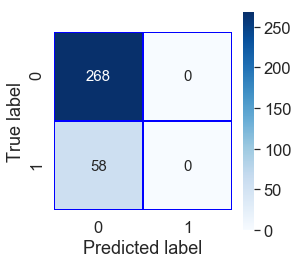

In [81]:
printReport(y_test1, preds)

### Training Model For Noise 2

In [76]:
model_checkpoint_2 = ModelCheckpoint('models/model_n2_2019-01-27.hdf5', verbose=1, save_best_only=True)

vgg_model_n2.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# history = vgg_model.fit(X_train, y, validation_split=0.2, batch_size=2, epochs=EPOCHS, callbacks=[model_checkpoint])

history_n2 = vgg_model_n2.fit_generator(trainDataFlow2,
                    steps_per_epoch=len(X_train2),
                    validation_data=valDataFlow2,
                    validation_steps=len(X_val2),
                    epochs=EPOCHS,
                    shuffle=True,
                    callbacks=[model_checkpoint_2, reduce_lr],
                    class_weight='auto')

Epoch 1/100
87/87 [==============================] - 8s 96ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00001: val_loss improved from inf to 5.86113, saving model to models/model_n2_2019-01-27.hdf5
Epoch 2/100
87/87 [==============================] - 8s 86ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00002: val_loss did not improve from 5.86113
Epoch 3/100
87/87 [==============================] - 7s 85ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00003: val_loss did not improve from 5.86113
Epoch 4/100
87/87 [==============================] - 7s 86ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00004: val_loss did not improve from 5.86113
Epoch 5/100
87/87 [==============================] - 8s 87ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00005: val_loss did not improve from 5.86113
Epoch 6/100
87/87 [============

87/87 [==============================] - 8s 89ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00045: val_loss did not improve from 5.86113
Epoch 46/100
87/87 [==============================] - 8s 89ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00046: val_loss did not improve from 5.86113
Epoch 47/100
87/87 [==============================] - 8s 89ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00047: val_loss did not improve from 5.86113
Epoch 48/100
87/87 [==============================] - 8s 89ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00048: val_loss did not improve from 5.86113
Epoch 49/100
87/87 [==============================] - 8s 89ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00049: val_loss did not improve from 5.86113
Epoch 50/100
87/87 [==============================] - 8s 89ms/step - loss: 7.9664 - acc:

87/87 [==============================] - 7s 79ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00089: val_loss did not improve from 5.86113
Epoch 90/100
87/87 [==============================] - 7s 82ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00090: val_loss did not improve from 5.86113
Epoch 91/100
87/87 [==============================] - 7s 78ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00091: val_loss did not improve from 5.86113
Epoch 92/100
87/87 [==============================] - 7s 79ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00092: val_loss did not improve from 5.86113
Epoch 93/100
87/87 [==============================] - 7s 81ms/step - loss: 7.9664 - acc: 0.5057 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00093: val_loss did not improve from 5.86113
Epoch 94/100
87/87 [==============================] - 8s 87ms/step - loss: 7.9664 - acc:

#### Evaluate On Test Set and Generate Report

326/326 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           0       0.44      1.00      0.61       144
           1       0.00      0.00      0.00       182

   micro avg       0.44      0.44      0.44       326
   macro avg       0.22      0.50      0.31       326
weighted avg       0.20      0.44      0.27       326



C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


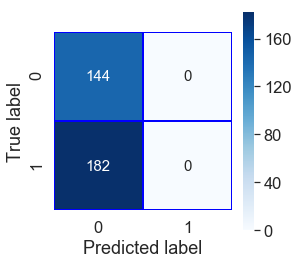

In [84]:
preds_2 = vgg_model_n2.predict(X_test, batch_size=9, verbose=1)
printReport(y_test2, preds_2)

### Training Model For Noise 3

In [83]:
model_checkpoint_3 = ModelCheckpoint('models/model_n3_2019-01-27.hdf5', verbose=1, save_best_only=True)

vgg_model_n3.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# history = vgg_model.fit(X_train, y, validation_split=0.2, batch_size=2, epochs=EPOCHS, callbacks=[model_checkpoint])

history_n3 = vgg_model_n3.fit_generator(trainDataFlow3,
                    steps_per_epoch=len(X_train3),
                    validation_data=valDataFlow3,
                    validation_steps=len(X_val3),
                    epochs=EPOCHS,
                    shuffle=True,
                    callbacks=[model_checkpoint_3, reduce_lr],
                    class_weight='auto')

Epoch 1/100
87/87 [==============================] - 9s 98ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00001: val_loss improved from inf to 5.86113, saving model to models/model_n3_2019-01-27.hdf5
Epoch 2/100
87/87 [==============================] - 7s 85ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00002: val_loss did not improve from 5.86113
Epoch 3/100
87/87 [==============================] - 7s 85ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00003: val_loss did not improve from 5.86113
Epoch 4/100
87/87 [==============================] - 7s 84ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00004: val_loss did not improve from 5.86113
Epoch 5/100
87/87 [==============================] - 7s 85ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00005: val_loss did not improve from 5.86113
Epoch 6/100
87/87 [============

87/87 [==============================] - 7s 85ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00045: val_loss did not improve from 5.86113
Epoch 46/100
87/87 [==============================] - 7s 82ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00046: val_loss did not improve from 5.86113
Epoch 47/100
87/87 [==============================] - 7s 81ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00047: val_loss did not improve from 5.86113
Epoch 48/100
87/87 [==============================] - 7s 79ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00048: val_loss did not improve from 5.86113
Epoch 49/100
87/87 [==============================] - 7s 80ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00049: val_loss did not improve from 5.86113
Epoch 50/100
87/87 [==============================] - 7s 82ms/step - loss: 6.2990 - acc:

87/87 [==============================] - 7s 80ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00089: val_loss did not improve from 5.86113
Epoch 90/100
87/87 [==============================] - 7s 80ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00090: val_loss did not improve from 5.86113
Epoch 91/100
87/87 [==============================] - 7s 79ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00091: val_loss did not improve from 5.86113
Epoch 92/100
87/87 [==============================] - 7s 85ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00092: val_loss did not improve from 5.86113
Epoch 93/100
87/87 [==============================] - 7s 83ms/step - loss: 6.2990 - acc: 0.6092 - val_loss: 5.8611 - val_acc: 0.6364

Epoch 00093: val_loss did not improve from 5.86113
Epoch 94/100
87/87 [==============================] - 7s 80ms/step - loss: 6.2990 - acc:

#### Evaluate On Test Set and Generate Report

326/326 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           0       0.37      1.00      0.54       120
           1       0.00      0.00      0.00       206

   micro avg       0.37      0.37      0.37       326
   macro avg       0.18      0.50      0.27       326
weighted avg       0.14      0.37      0.20       326



C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


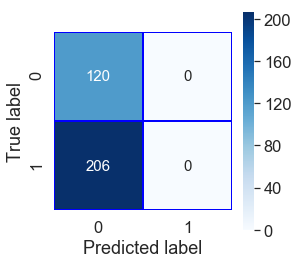

In [85]:
preds_3 = vgg_model_n3.predict(X_test, batch_size=9, verbose=1)
printReport(y_test3, preds_3)